In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from cycler import cycler
import random
#import sympy as sym

from fredapi import Fred
fred = Fred(api_key='Enter API Key Here')
%matplotlib inline

In [2]:
# ST rates
EFFR = fred.get_series('DFF')
ytm_1mo = fred.get_series('DGS1MO')
ytm_3mo = fred.get_series('DGS3MO')
ytm_6mo = fred.get_series('DGS6MO')

In [156]:
def bond_value(TtMaturity,Coupon_rate,Market_rate,Par=1000):
    periods = list(range(1,TtMaturity+1))
    Coupon = Coupon_rate * Par
    Coupon_mkt_req = Market_rate * Par

    # Check Discount/Premium/Par bond by comparing Coupon and Market rates
    Bond_type_from_rates = None
    if Coupon_rate < Market_rate:
        Bond_type_from_rates = 'Discount Bond'
    elif Coupon_rate > Market_rate:
        Bond_type_from_rates = 'Premium Bond'
    elif Coupon_rate == Market_rate:
        Bond_type_from_rates = 'Par Bond'

    # Create df with bond Cash Flows
    bondCF = [Coupon + Par if t==len(periods) else Coupon for t in periods]
    bondCF_mkt_req = [Coupon_mkt_req + Par if t==len(periods) else Coupon_mkt_req for t in periods]

    bond_dct = dict(zip(periods,bondCF))
    bond_df = pd.DataFrame(bond_dct.items(), columns = ['periods','bondCF'])

    # Create hypothetical bond CF required by the market to make bond issued at par
    bond_df['bondCF_mkt_req'] = bondCF_mkt_req
    bond_df['bondCF-mkt_reqCF'] = bond_df['bondCF'] - bond_df['bondCF_mkt_req']

    # Bond Valuation
    discount_factor = (1+Market_rate)

    bond_df['discount_factor'] = (1/discount_factor) ** bond_df['periods']
    bond_df['PV of bondCF'] = bond_df['bondCF'] * bond_df['discount_factor']
    bond_valuation = bond_df['PV of bondCF'].sum()

    return bond_valuation


def bond_analysis(TtMaturity,Coupon_rate,Market_rate,Par=1000):
    periods = list(range(1,TtMaturity+1))
    Coupon = Coupon_rate * Par
    Coupon_mkt_req = Market_rate * Par
    
    # Check Discount/Premium/Par bond by comparing Coupon and Market rates
    Bond_type_from_rates = None
    if Coupon_rate < Market_rate:
        Bond_type_from_rates = 'Discount Bond'
    elif Coupon_rate > Market_rate:
        Bond_type_from_rates = 'Premium Bond'
    elif Coupon_rate == Market_rate:
        Bond_type_from_rates = 'Par Bond'
    
    print(f'Bond Type: {Bond_type_from_rates}')

    # Create df with bond Cash Flows
    bondCF = [Coupon + Par if t==len(periods) else Coupon for t in periods]
    bondCF_mkt_req = [Coupon_mkt_req + Par if t==len(periods) else Coupon_mkt_req for t in periods]

    bond_dct = dict(zip(periods,bondCF))
    bond_df = pd.DataFrame(bond_dct.items(), columns = ['periods','bondCF'])
    
    # Create hypothetical bond CF required by the market to make bond issued at par
    bond_df['bondCF_mkt_req'] = bondCF_mkt_req
    bond_df['bondCF-mkt_reqCF'] = bond_df['bondCF'] - bond_df['bondCF_mkt_req']

    # Bond Valuation
    discount_factor = (1+Market_rate)
    
    bond_df['discount_factor'] = (1/discount_factor) ** bond_df['periods']
    bond_df['PV of bondCF'] = bond_df['bondCF'] * bond_df['discount_factor']
    bond_valuation = bond_df['PV of bondCF'].sum()

    # Difference between Bond PV and par = Discount/Premium/None 
    # Discount (Negative differnce), Premium (Positive difference) are Amortized (cost allocated each period)
    Bond_Amortization_t0 = bond_valuation - Par
    #Par + Bond_Amortization_t0 == bond_valuation
   
    Bond_type_from_value_diff = None
    if Bond_Amortization_t0.round(4) < 0:
        Bond_type_from_value_diff = 'Discount Bond'
    elif Bond_Amortization_t0.round(4) > 0:
        Bond_type_from_value_diff = 'Premium Bond'
    elif Bond_Amortization_t0.round(4) == 0:
        Bond_type_from_value_diff = 'Par Bond'
    
    print(f'Bond Type (Checking): {Bond_type_from_value_diff} ({Bond_type_from_rates==Bond_type_from_value_diff})')

    # Bond Issuer Accounting 
    bond_liabilities = []
    Amortized_Exp = []
    Amortized_BV = []
    Interest_Exp = []

    for t in periods:
        # year 0 Bond price not shown in the df
        bond_liabilities_t0 = Par + Bond_Amortization_t0 # negative value (Discount), positive (Premium)

        if t == 1: # year 1
            Int_exp = bond_liabilities_t0 * Market_rate # positive value (both Discount and Premium bonds)
            Interest_Exp.append(Int_exp)

            Amort_exp = Int_exp - Coupon # positive value (both Discount and Premium bonds)
            Amortized_Exp.append(Amort_exp)

            Amort_BV = Bond_Amortization_t0 + Amort_exp
            Amortized_BV.append(Amort_BV)

            Bond_BV = Par + Amort_BV
            bond_liabilities.append(Bond_BV)

        else:  
            Int_exp = bond_liabilities[-1] * Market_rate
            Interest_Exp.append(Int_exp)

            Amort_exp = Int_exp - Coupon # positive value (both Discount and Premium bonds)
            Amortized_Exp.append(Amort_exp)

            Amort_BV = Amortized_BV[-1] + Amort_exp # negative value (Discount), positive (Premium)
            Amortized_BV.append(Amort_BV)

            Bond_BV = Par + Amort_BV
            bond_liabilities.append(Bond_BV)

    # bond_liabilities = np.around(bond_liabilities,2)
    # Interest_Exp = np.around(Interest_Exp,2)
    # Amortized_Exp = np.around(Amortized_Exp,2)
    # Amortized_BV = np.around(Amortized_BV,2)

    bond_df['Interest_Exp'] = Interest_Exp
    bond_df['Amortized_Exp'] = Amortized_Exp
    bond_df['Amortized_BV'] = Amortized_BV
    bond_df['bond_BV'] = bond_liabilities
    
    print(f'Bond Valuation: ${bond_valuation.round(4)}')
    
    return bond_valuation, bond_df

def Price_given_yield(TtMaturity,Coupon_rate,Market_rate,Par):
    df = pd.DataFrame(Market_rate, columns=['Market_rate'])
    BV_lst = []
    
    for n in range(len(Market_rate)):
        MR = Market_rate.iloc[n]
        bv = bond_value(TtMaturity,Coupon_rate,MR,Par)
        BV_lst.append(bv)
    
    df['bond_value'] = BV_lst
    
    return df

def BV_on_RF(Yield_data):
    TtMaturity = [1, 2, 3, 5, 7, 10, 20, 30]
    Par = 1000
    Coupon_rate = 0
    
    for T in range(len(TtMaturity)):

        Market_rate = Yield_data[T].dropna()/100
        df = Price_given_yield(TtMaturity[T],Coupon_rate,Market_rate,Par)

        fig, ax1 = plt.subplots(figsize=(10,6))
        ax2 = ax1.twinx()

        ax1.plot(df['bond_value'], label='bond_value',color='r')
        ax2.plot(df['Market_rate'], label='Market_rate')

        plt.title(f'Market Yield of T={TtMaturity[T]} year(s) and Bond Valuation')
        plt.xlabel('Periods (t)')
        ax1.set_ylabel('Bond Valuations (Book Value) in $ (P)')
        ax2.set_ylabel('Market Yield (y)')
        plt.grid()
        fig.legend();

In [29]:
TtMaturity = 3
Market_rate = 0.1
Par = 100
Coupon_rate = 0.08

bond_valuation, bond_df = bond_analysis(TtMaturity,Coupon_rate,Market_rate,Par=100)

# Sum of PV of difference in CF on bond and CF required by the market equals the Discount or Premium (Amortized at t0)
a = (bond_df['bondCF-mkt_reqCF'] * bond_df['discount_factor']).sum().round(4)
b = -bond_df['Amortized_Exp'].sum().round(4) #== Bond_Amortization_t0.round(4)

a == b, f'Premium(+)/Discount(-): ${a}'

Bond Type: Discount Bond
Bond Type (Checking): Discount Bond (True)
Bond Valuation: $95.0263


(True, 'Premium(+)/Discount(-): $-4.9737')

In [30]:
# Actual cash paid on bond - Actually Borrowed by Issuer(Bond Price) = Total Interest Expense 
# Total Interest Expense is recognized in Issuer's I/S
a = (bond_df['bondCF'].sum() - bond_valuation).round(4) 
b = bond_df['Interest_Exp'].sum().round(4)

a == b, f'Total Interest Expense: ${a}'

(True, 'Total Interest Expense: $28.9737')

Bond Type: Par Bond
Bond Type (Checking): Par Bond (True)
Bond Valuation: $100.0
Bond Type: Discount Bond
Bond Type (Checking): Discount Bond (True)
Bond Valuation: $90.5731
Bond Type: Premium Bond
Bond Type (Checking): Premium Bond (True)
Bond Valuation: $109.4269
Bond Type: Discount Bond
Bond Type (Checking): Discount Bond (True)
Bond Valuation: $95.0826
Capital Gains: 4.3176702270247915, Non-Capital Gains: 0.09229599817706458, Total P&L: 4.409966225201856


True

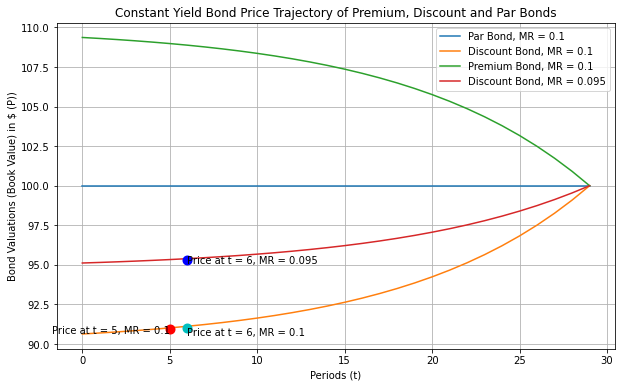

In [145]:
### Constant Yield Bond Price Trajectory of a Bond given a constatnt Market Yield
TtMaturity = 30
Market_rate = 0.1
Par = 100

# Par bond (Coupon_rate = Market_rate)
Coupon_rate = 0.1
bond_valuation_par, bond_df_par = bond_analysis(TtMaturity,Coupon_rate,Market_rate,Par=100)

# Discount bond (Coupon_rate < Market_rate)
Coupon_rate = 0.09
bond_valuation_dis, bond_df_dis = bond_analysis(TtMaturity,Coupon_rate,Market_rate,Par=100)

# Premium bond (Coupon_rate > Market_rate)
Coupon_rate = 0.11
bond_valuation_prem, bond_df_prem = bond_analysis(TtMaturity,Coupon_rate,Market_rate,Par=100)

# Graph Bond Price Trajectories
plt.figure(figsize=(10,6))
plt.plot(bond_df_par['bond_BV'], label=f'Par Bond, MR = {Market_rate}')
plt.plot(bond_df_dis['bond_BV'], label=f'Discount Bond, MR = {Market_rate}')
plt.plot(bond_df_prem['bond_BV'], label=f'Premium Bond, MR = {Market_rate}')

# Zero Coupon Bond
# Coupon_rate = 0
# bond_valuation_ZCB, bond_df_ZCB = bond_analysis(TtMaturity,Coupon_rate,Market_rate,Par)
# plt.plot(bond_df_ZCB['bond_BV'], label=f'Zero Coupon Bond, MR = {Market_rate}')


# Assume a current price point
Coupon_rate = 0.09
t = 5
T = TtMaturity - t
P_0 = bond_value(T,Coupon_rate,Market_rate,Par)
plt.plot(t, P_0,'ro', markersize = 5, markeredgewidth=5)
plt.text(t, P_0, s=f'Price at t = {t}, MR = {Market_rate}', horizontalalignment='right', verticalalignment='center_baseline')


# If the Market Yield changes
Market_rate_new = 0.095
bond_valuation_1, bond_df_1 = bond_analysis(TtMaturity,Coupon_rate,Market_rate_new,Par)
plt.plot(bond_df_1['bond_BV'], label=f'Discount Bond, MR = {Market_rate_new}')

# Assume a next period selling price point and calculate Capital Gains
t = 6
T = TtMaturity - t

P_1const_y = bond_value(T,Coupon_rate,Market_rate,Par)
plt.plot(t, P_1const_y,'co', markersize = 5, markeredgewidth=5)
plt.text(t, P_1const_y, s=f'Price at t = {t}, MR = {Market_rate}', horizontalalignment='left', verticalalignment='top')

P_1 = bond_value(T,Coupon_rate,Market_rate_new,Par)
plt.plot(t, P_1,'bo', markersize = 5, markeredgewidth=5)
plt.text(t, P_1, s=f'Price at t = {t}, MR = {Market_rate_new}', horizontalalignment='left', verticalalignment='center_baseline')



#plt.title(f'Constant Yield Bond Price Trajectory of a Bond with Coupon Rate = {Coupon_rate} at Market Rate = {Market_rate}')
plt.title(f'Constant Yield Bond Price Trajectory of Premium, Discount and Par Bonds')
plt.xlabel('Periods (t)')
plt.ylabel('Bond Valuations (Book Value) in $ (P))')
plt.grid()
plt.legend();

# Total P&L from selling the bond after market rate changes
Selling_PnL = P_1 - P_0

# Capital Gains from selling using assumed price that the yield remained constant in next period
CG = P_1 - P_1const_y

# Non-Capital Gains portion of selling P&L, due to movement along the constant yield trajectory
# this is due to decrease in Term to Maturity, less discounting periods, changing PV of the bond
Non_CG = Selling_PnL - CG

# Non-Capital Gains movement can also be calculated using the price movement in the trajectory
P_1_consy = bond_df_dis[bond_df_dis['periods'] == t]['bond_BV'].values
P_0_consy = bond_df_dis[bond_df_dis['periods'] == (t-1)]['bond_BV'].values

print(f'Capital Gains: {CG}, Non-Capital Gains: {Non_CG}, Total P&L: {Selling_PnL}')
P_1_consy[0] - P_0_consy[0] == Non_CG


In [132]:
#yields = np.linspace(0,5, 100)
yields = pd.Series(np.arange(0, 0.3+0.01, 0.01))
TtMaturity = 3
Coupon_rate = 0.1
Par = 100

P_df = Price_given_yield(TtMaturity,Coupon_rate,yields,Par)

Current_yield_level = random.choice(yields)
Current_P = P_df[P_df['Market_rate'] == Current_yield_level]['bond_value'].values[0]
print(f'Yield: {Current_yield_level}, Current Price: {Current_P}')

bond_valuation_current, bond_df_current = bond_analysis(TtMaturity,Coupon_rate,Current_yield_level,Par)

Yield: 0.09, Current Price: 102.53129466598816
Bond Type: Premium Bond
Bond Type (Checking): Premium Bond (True)
Bond Valuation: $102.5313


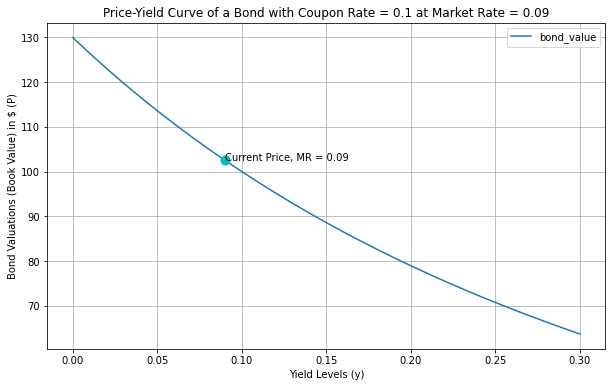

In [137]:
plt.figure(figsize=(10,6))
plt.plot(P_df['Market_rate'], P_df['bond_value'], label='bond_value')
plt.plot(Current_yield_level, Current_P,'co', markersize = 5, markeredgewidth=5)
plt.text(Current_yield_level, Current_P, s=f'Current Price, MR = {Current_yield_level}')

plt.title(f'Price-Yield Curve of a Bond with Coupon Rate = {Coupon_rate} at Market Rate = {Current_yield_level}')
plt.xlabel('Yield Levels (y)')
plt.ylabel('Bond Valuations (Book Value) in $ (P)')
plt.grid()
plt.legend();

In [157]:
ytm_1y = fred.get_series('DGS1')
ytm_2y = fred.get_series('DGS2')
ytm_3y = fred.get_series('DGS3')
ytm_5y = fred.get_series('DGS5')
ytm_7y = fred.get_series('DGS7')
ytm_10y = fred.get_series('DGS10')
ytm_20y = fred.get_series('DGS20')
ytm_30y = fred.get_series('DGS30')

Yield_data = [ytm_1y, ytm_2y, ytm_3y, ytm_5y, ytm_7y, ytm_10y, ytm_20y, ytm_30y]

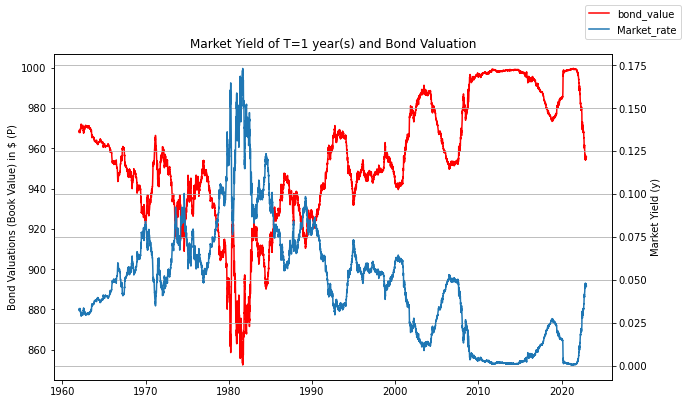

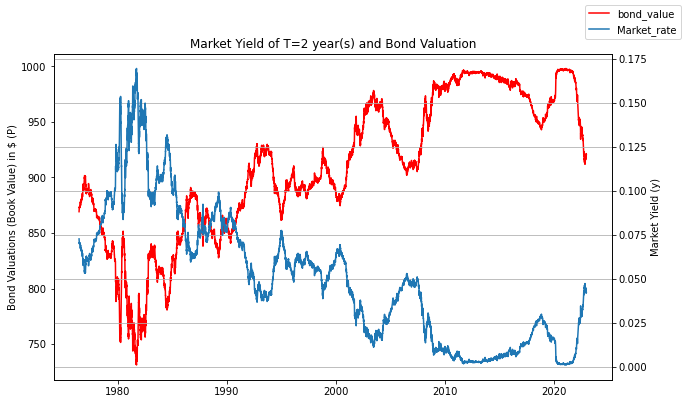

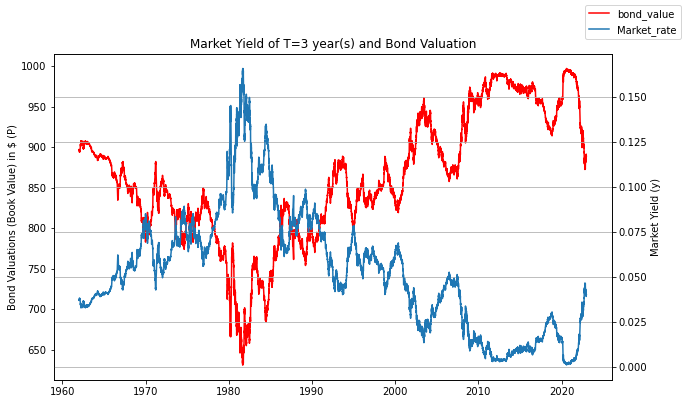

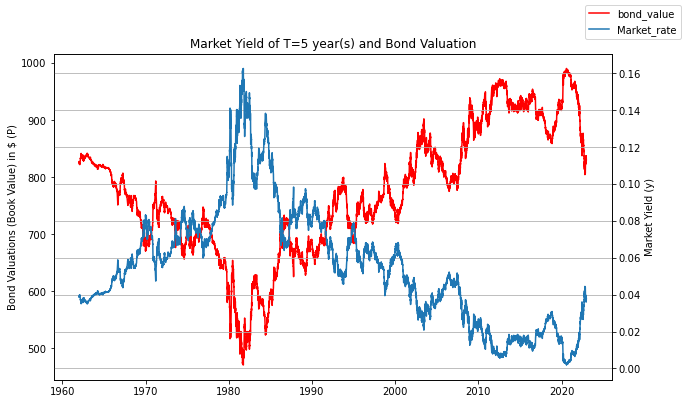

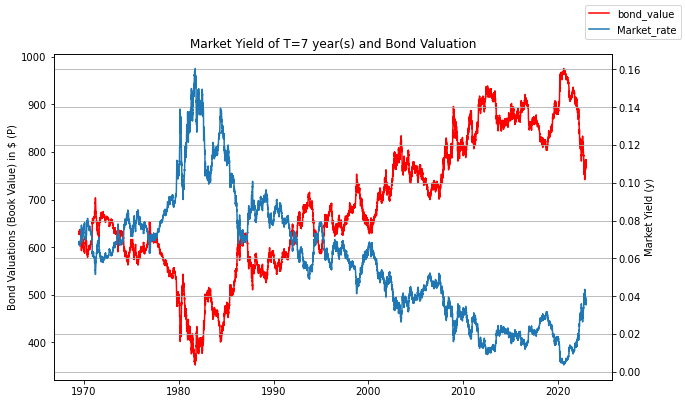

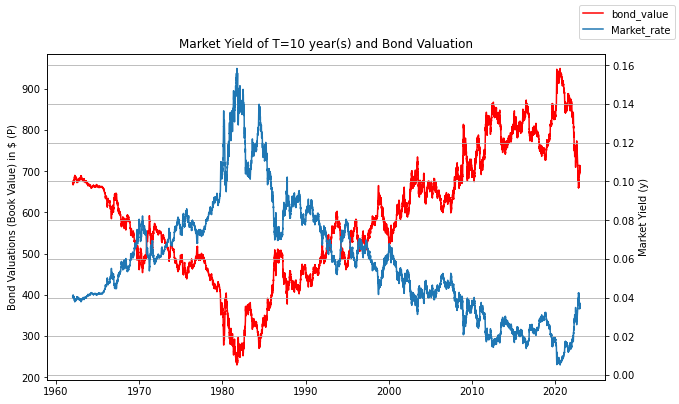

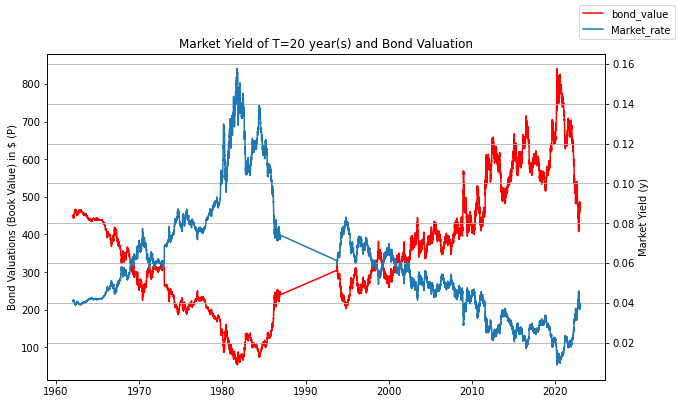

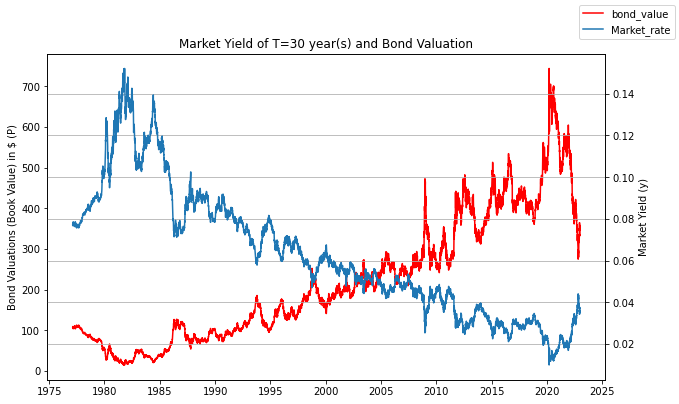

In [155]:
BV_on_RF(Yield_data)